In [1]:
from tqdm import tqdm
import sys
import json
import random
import math

random.seed(0)
sys.path.append('../../')

<h1>2-2. Word2Vec: Skip Gram<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Negative-sampling" data-toc-modified-id="Negative-sampling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Negative sampling</a></span></li><li><span><a href="#Build-the-model" data-toc-modified-id="Build-the-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build the model</a></span></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train the model</a></span><ul class="toc-item"><li><span><a href="#LR-range-test" data-toc-modified-id="LR-range-test-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LR range test</a></span></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train the model</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Embedding-plot" data-toc-modified-id="Embedding-plot-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Embedding plot</a></span></li><li><span><a href="#$n$-most-similar" data-toc-modified-id="$n$-most-similar-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>$n$-most similar</a></span></li></ul></li></ul></div>

## Negative sampling

In [2]:
from utils import *

In [3]:
words, vocab, freq, word_to_ix = get_gutenberg_tokens()
sum_freq = sum(freq)

* subsampling

$$P(w_i) = \left( \sqrt{\frac{z(w_i)}{t}} + 1 \right) \times \frac{t}{z(w_i)},~~ t=10^{-3}.$$

In [4]:
def subsample_prob(word, t=1e-3):
    z = freq[word_to_ix[word]] / sum_freq
    return (math.sqrt(z/t) + 1) * t/z

words_subsample = [w for w in words if random.random() < subsample_prob(w)]

In [5]:
len(words), len(words_subsample)

(2621613, 1819746)

* negative sampling (hinted by [the post](https://tech.hbc.com/2018-03-23-negative-sampling-in-numpy.html))

```python
from multiprocessing import Pool
import json

def build_sample(words, vocab=vocab, freq=freq, c=2, k=2, use_neg_prob=True):
    """
    build dataset with negative sampling. Default context size is `c=2`.
    Ratio between positive and negative samples will be 1:k (default: `k=2`).
    """
    x, y = [], []
    vocab = np.array(vocab)
    freq = np.array(freq)
    wordix = seq_to_ix(words)
    for i in tqdm(range(len(words)-c)):
        current = wordix[i]
        context_pos = wordix[i+1:i+c+1]

        # negative sampling probability
        pos_idx_adj = np.sort(np.unique(wordix[i:i+c+1]))
        pos_idx_adj -= np.arange(len(pos_idx_adj))
        neg_idx = np.arange(len(freq)-c-1)
        neg_idx += np.searchsorted(pos_idx_adj, neg_idx, side='right')
        freq_neg = freq[neg_idx]

        if use_neg_prob:
            probs = reweight_prob(freq_neg)
        else:
            probs = freq_neg / freq_neg.sum()

        context_neg = seq_to_ix(np.random.choice(vocab[neg_idx], 
                                                 c*k, 
                                                 replace=False,
                                                 p=probs))

        # positive samples + negative samples
        #context = context_pos + context_neg
        #current = [current] * len(context)
        labels = [[1] + [0] * k] * c

        for j, x_pos in enumerate(context_pos):
            x.append([(current, x_pos)] + list(zip([current]*c, context_neg[j:j+c])))
        y += labels

    return x, y
        

def reweight_prob(freq):
    """
    Re-weight negative sampling probability according to word frequency.
    Negative sampling probability: U(w_i)^{3/4} / \\sum_{j=1}^n U(w_j)^{3/4}
    where U(w_i) is a unigram frequency of word w_i.
    """
    freq_adj = freq**.75
    neg_sampling_probs = freq_adj / freq_adj.sum()
    return neg_sampling_probs


def seq_to_ix(seq, word_to_ix=word_to_ix):
    return list(map(lambda w: word_to_ix[w], seq))
```

```python
n_workers = 32
words_chunk = []
chunksize = len(words_subsample) // n_workers + 1

for i in range(0, len(words_subsample), chunksize):
    words_chunk.append(words_subsample[i:i+chunksize])

with Pool(n_workers) as p:
    res = p.map(build_sample, words_chunk)

x, y = [], []
for i in range(n_workers):
    x += res[i][0]
    y += res[i][1]

with open("./negative_sampling.json", "w") as w:
    json.dump({"data": x, "label": y}, w)
```

In [6]:
with open("./negative_sampling.json") as r:
    data = json.load(r)

* transform into torch dataset

In [7]:
x = data["data"]
y = data["label"]

In [8]:
trainset = torch.utils.data.TensorDataset(torch.LongTensor(x),
                                          torch.Tensor(y))
trainset = torch.utils.data.DataLoader(trainset, batch_size=2048, shuffle=True)

## Build the model

![skipgram.png](https://d3i71xaburhd42.cloudfront.net/a1d083c872e848787cb572a73d97f2c24947a374/5-Figure1-1.png)

In [9]:
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 100

In [10]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        
        # embeddings
        self.embedding_u = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_v = nn.Embedding(vocab_size, embedding_dim)
        
    def forward(self, x):
        # input should be of shape [batch_size, 1+k, 2]
        # split positive and negative sample
        x_pos_1, x_pos_2 = x[:, 0, :].T
        x_neg_1, x_neg_2 = x[:, 1:, :].T
        
        # log-likelihood w.r.t. x_pos
        u = self.embedding_u(x_pos_1)
        v = self.embedding_v(x_pos_2)
        x_pos = (u * v).sum(dim=1).view(1, -1)
        
        # log-likelihood w.r.t. x_neg
        u = self.embedding_u(x_neg_1)
        v = self.embedding_v(x_neg_2)
        x_neg = (u * v).sum(dim=2)
        
        x = torch.cat((x_pos, x_neg)).T
        
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Train the model

### LR range test

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.85E+01


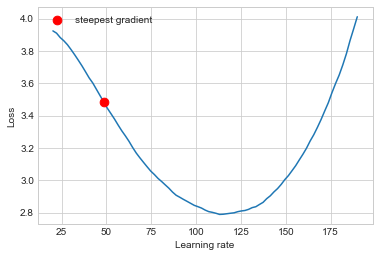

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 48.48484856060607)

In [12]:
from torch_lr_finder import LRFinder

model = SkipGram(VOCAB_SIZE, EMBEDDING_DIM)
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainset, end_lr=200, num_iter=100, step_mode="linear")
lr_finder.plot(log_lr=False)

### Train the model

In [17]:
model = SkipGram(VOCAB_SIZE, EMBEDDING_DIM)
model.to(device)

SkipGram(
  (embedding_u): Embedding(42339, 100)
  (embedding_v): Embedding(42339, 100)
)

In [18]:
optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

In [19]:
def accuracy(pred):
    pred = (torch.sigmoid(pred) > 0.5).int()
    target = torch.cuda.LongTensor([1, 0, 0])
    correct = ((pred == target).sum(dim=1) == 3)
    return correct.sum() / len(correct)

In [20]:
N_EPOCH = 50
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=110.,  # from LR range test plot
    epochs=N_EPOCH, 
    steps_per_epoch=len(trainset)
)

losses, accs = [], []
for i in range(1, N_EPOCH+1):
    loss_epoch = 0.
    acc_epoch = 0.
    for batch, target in trainset: #, position=0, leave=True, desc=f"Epoch {i:03}"):
        
        x = batch.to(device)
        target = target.to(device)

        model.zero_grad()
        pred = model(x)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        loss_epoch += loss.item()
        acc_epoch += accuracy(pred).item()
    
    losses.append(loss_epoch/len(trainset))
    accs.append(acc_epoch/len(trainset))
    
    if i % 1 == 0:
        print(f"epoch: {i:03}, loss: {loss_epoch/len(trainset): .3f}, acc: {acc_epoch/len(trainset): .4f}")

epoch: 001, loss:  1.334, acc:  0.1679
epoch: 002, loss:  0.820, acc:  0.2245
epoch: 003, loss:  0.690, acc:  0.2701
epoch: 004, loss:  0.644, acc:  0.3004
epoch: 005, loss:  0.635, acc:  0.3167
epoch: 006, loss:  0.637, acc:  0.3259
epoch: 007, loss:  0.640, acc:  0.3310
epoch: 008, loss:  0.643, acc:  0.3351
epoch: 009, loss:  0.643, acc:  0.3400
epoch: 010, loss:  0.646, acc:  0.3429
epoch: 011, loss:  0.645, acc:  0.3460
epoch: 012, loss:  0.645, acc:  0.3491
epoch: 013, loss:  0.639, acc:  0.3537
epoch: 014, loss:  0.637, acc:  0.3577
epoch: 015, loss:  0.629, acc:  0.3621
epoch: 016, loss:  0.625, acc:  0.3661
epoch: 017, loss:  0.613, acc:  0.3715
epoch: 018, loss:  0.607, acc:  0.3753
epoch: 019, loss:  0.602, acc:  0.3793
epoch: 020, loss:  0.593, acc:  0.3836
epoch: 021, loss:  0.585, acc:  0.3882
epoch: 022, loss:  0.584, acc:  0.3906
epoch: 023, loss:  0.577, acc:  0.3942
epoch: 024, loss:  0.567, acc:  0.3998
epoch: 025, loss:  0.558, acc:  0.4045
epoch: 026, loss:  0.549,

```python
torch.save(
    model.state_dict(), 
    "./saved_model/SkipGram_SGD_lr0.5+110.0+onecycle_momentum0.9_epoch50.pth"
)
```

In [23]:
model = SkipGram(VOCAB_SIZE, EMBEDDING_DIM)
model.load_state_dict(torch.load("./saved_model/SkipGram_SGD_lr0.5+110.0+onecycle_momentum0.9_epoch50.pth"))

<All keys matched successfully>

## Results

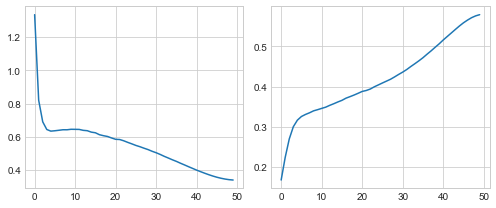

In [24]:
plot_train(losses, accs);

### Embedding plot

In [25]:
def embedding(word_idx):
    u = model.embedding_u.weight[word_idx]
    v = model.embedding_v.weight[word_idx]
    return ((u + v) / 2).cpu()

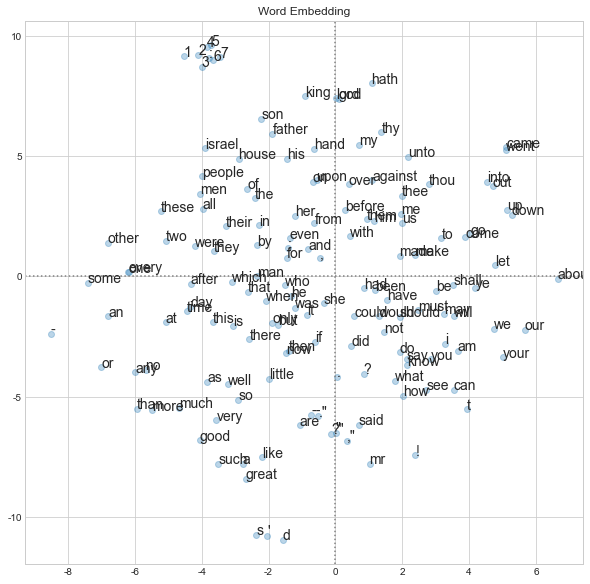

In [26]:
plot_embedding(words_subsample, embedding, word_to_ix);

### $n$-most similar

In [27]:
for word in ["angel", "snow", "love", "death"]:
    print(find_similar(word, words, embedding, word_to_ix))

['isaiah', 'spake', 'jesus', 'lord', 'rachel']
['mid', 'ice', 'storm', 'bodily', 'wind']
['sing', 'esteem', 'faith', 'tempt', 'rejoice']
['life', 'hell', 'presence', 'battle', 'dead']
